In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import time
import copy

import matplotlib.pyplot as plt

import ase.io

import sklearn.model_selection

from utils.dataset import AtomisticDataset, create_dataloader
from utils.soap import PowerSpectrum
from utils.combine import CombineSpecies, CombineRadial, CombineRadialSpecies
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient

torch.set_default_dtype(torch.float64)

In [3]:
n_test = 100
n_train = 400

frames = ase.io.read("data/elpasolites_10590.xyz", f":")
energies = torch.tensor(np.loadtxt("data/elpasolites_10590_evpa.dat"))

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = energies[:n_train].reshape(-1, 1)
test_energies = energies[-n_test:].reshape(-1, 1)

print(f"using {n_train} training frames")

using 400 training frames


In [4]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

HYPERS_FROM_PAPER = {
    "cutoff": 5.0,
    "max_angular": 9,
    "max_radial": 12,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto": {}},
    "center_atom_weight": 1.0,
    "gradients": False,
}

HYPERS_SMALL = {
    "cutoff": 5.0,
    "max_angular": 3,
    "max_radial": 4,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto": {}},
    "center_atom_weight": 1.0,
    "gradients": False,
}

# Optimization loop

In [5]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

In [6]:
train_dataset = AtomisticDataset(train_frames, all_species, HYPERS_SMALL, train_energies)
test_dataset = AtomisticDataset(test_frames, all_species, HYPERS_SMALL, test_energies)

In [7]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    device=device,
)

In [8]:
def loss_optimizer(predicted, actual, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_mae(predicted, actual):
    return torch.mean(torch.abs(predicted.flatten() - actual.flatten()))

def loss_mse(predicted, actual):
    return torch.mean((predicted.flatten() - actual.flatten())**2)

In [9]:
class CombinedLinearModel(torch.nn.Module):
    def __init__(self, 
        combiner,
        regularizer,
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()
        self.combiner = combiner
        self.power_spectrum = PowerSpectrum()
        self.model = LinearModel(
            regularizer=regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )

        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, spherical_expansion, forward_forces=False):
        if not forward_forces:
            # remove gradients from the spherical expansion if we don't need it
            spherical_expansion = remove_gradient(spherical_expansion)

        combined = self.combiner(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)        
        power_spectrum_per_structure = self.sum_structure(power_spectrum)
        energies, forces = self.model(power_spectrum_per_structure, with_forces=forward_forces)
        return energies, forces

    def initialize_model_weights(self, spherical_expansion, energies, forces=None):
        if forces is None:
            # remove gradients from the spherical expansion if we don't need it
            spherical_expansion = remove_gradient(spherical_expansion)

        combined = self.combiner(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        
        power_spectrum_per_structure = self.sum_structure(power_spectrum)
        self.model.initialize_model_weights(power_spectrum_per_structure, energies, forces)
        

In [10]:
N_PSEUDO_SPECIES = 4
TORCH_REGULARIZER = 1e-2
LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

N_COMBINED_RADIAL = 4

# species combination only
combiner = CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES)

# # species combination and then radial basis combination
# combiner = torch.nn.Sequential(
#     CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES),
#     CombineRadial(max_radial=HYPERS_SMALL["max_radial"], n_combined_radial=N_COMBINED_RADIAL),
# )

# # combine both radial and species information at the same time
# combiner = CombineRadialSpecies(
#     n_species=len(all_species), 
#     max_radial=HYPERS_SMALL["max_radial"], 
#     n_combined_basis=N_COMBINED_RADIAL*N_PSEUDO_SPECIES,
# )

model = CombinedLinearModel(
    combiner=combiner, 
    regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True,
    random_initial_weights=True,
)

In [11]:
model.to(device=device, dtype=torch.get_default_dtype())

# initialize the model
with torch.no_grad():
    for _, _, spherical_expansions, energies, _ in train_dataloader_no_batch:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        model.initialize_model_weights(spherical_expansions, energies)

if model.optimizable_weights:
    torch_loss_regularizer = TORCH_REGULARIZER
else:
    torch_loss_regularizer = 0
    # we can not use batches if we are training with linear algebra, we need to
    # have all training frames available
    assert train_dataloader.batch_size >= len(train_frames)

In [12]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)

all_losses = []

filename = f"{model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if model.optimizable_weights:
    filename += "-opt-weights"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [13]:
for epoch in range(10):
    assert model.optimizable_weights

    epoch_start = time.time()
    
    def single_step():
        optimizer.zero_grad()
        for _, _, spherical_expansions, energies, _ in train_dataloader:                
            predicted, _ = model(spherical_expansions, forward_forces=False)

            loss = loss_optimizer(
                predicted, 
                energies, 
                torch_loss_regularizer, 
                model.model.weights
            )
            loss.backward(retain_graph=False)

        return loss
            
    loss = optimizer.step(single_step)
    all_losses.append(loss.item())

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            reference = []
            for _, _, spherical_expansions, energies, _ in test_dataloader:
                reference.append(energies)
                predicted_e, _ = model(spherical_expansions, forward_forces=False)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted, reference)

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss.item():.4}, test mae={mae:.4}")
        
    n_epochs_total += 1

epoch 0 took 5.207s, optimizer loss=5.564e+03, test mae=0.9786
epoch 1 took 5.044s, optimizer loss=660.5, test mae=0.6516
epoch 2 took 5.142s, optimizer loss=267.9, test mae=0.5533
epoch 3 took 5.086s, optimizer loss=150.1, test mae=0.512
epoch 4 took 5.109s, optimizer loss=89.33, test mae=0.4997
epoch 5 took 5.099s, optimizer loss=59.98, test mae=0.5147
epoch 6 took 5.169s, optimizer loss=43.79, test mae=0.4659
epoch 7 took 5.027s, optimizer loss=35.45, test mae=0.4304
epoch 8 took 5.118s, optimizer loss=29.28, test mae=0.4407
epoch 9 took 5.109s, optimizer loss=26.31, test mae=0.4651


In [16]:
def evaluate_model(model, dataloader):
    predicted_e = []
    reference_e = []
    for _, _, spherical_expansions, energies, _ in dataloader:
        reference_e.append(energies)
        e, f = model(spherical_expansions)
        predicted_e.append(e)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)    

    return reference_e, predicted_e

def parity_plots(reference_e, predicted_e):
    predicted_e = predicted_e.detach()

    fig, (ax_e) = plt.subplots(1, 1, figsize=(8, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = torch.sqrt(loss_mse(predicted_e, reference_e))
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    return fig

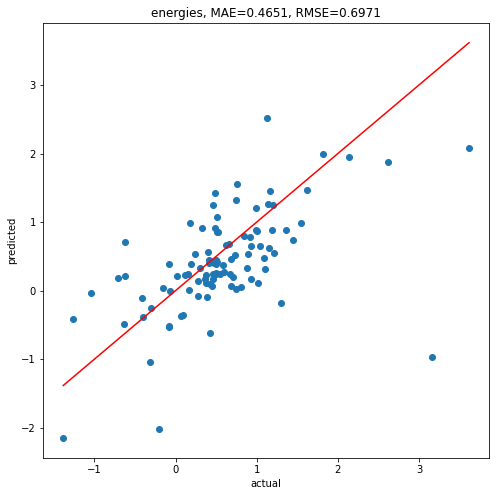

In [17]:
fig = parity_plots(*evaluate_model(model, test_dataloader))